In [1]:
import numpy as np
numpy = np
from matplotlib import pyplot as plt
# from skimage.color import rgb2gray
# from skimage.data import stereo_motorcycle, vortex
# from skimage.transform import warp
# from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage import io
import ants
import scipy.ndimage as ndimage
from glob import glob
import tempfile
import nibabel
from scipy.ndimage import gaussian_filter
# import math
from nighres.io import load_volume, save_volume
import os
import sys
# sys.path.append('/home/chris/Documents/code/nighres')
import nighres



In [2]:
from contextlib import contextmanager

@contextmanager
def working_directory(path):
    """ 
        Helper function to change our current working directory to 
        ensure that temporary files created by ANTs are saved in the 
        correct directory, as specified. 

        ANTs will save temporary files in the current working directory under some conditions :(
    """
    prev_cwd = os.getcwd()
    os.makedirs(path, exist_ok=True)
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(prev_cwd)
        
def do_reg(sources, targets, run_rigid=True, run_syn=False, file_name='XXX', output_dir='./', scaling_factor=64, mask_zero=False):
    """
    Helper function to perform registration between source and target images using ANTsPy w/ nighres
            course_iterations=100,
        medium_iterations=100,
        fine_iterations=50,
    """

    with working_directory(output_dir):
        reg = nighres.registration.embedded_antspy_2d_multi(
            source_images=sources,
            target_images=targets,
            run_rigid=run_rigid,
            run_affine=False,
            run_syn=run_syn,
            scaling_factor=scaling_factor,
            cost_function='MutualInformation',
            interpolation='Linear',
            regularization='High',
            convergence=1e-6,
            mask_zero=mask_zero,
            ignore_affine=False, 
            ignore_orient=False, 
            ignore_res=False,
            save_data=True, 
            overwrite=True,
            file_name=file_name, 
            output_dir=output_dir
        )
    return reg

In [3]:
def do_reg_ants(sources, targets, run_rigid=True, run_syn=False,
                file_name='reg', output_dir='./', scaling_factor=64,
                mask_zero=False, syn_flow_sigma=3, syn_total_sigma=0):

    """
    Perform registration between source and target images using ANTsPy,
    mimicking the manual pipeline: rigid first, then SyN (optional).
    
    Parameters:
        sources, targets: list of image file paths (length 1 each expected)
        run_rigid: if True, perform rigid registration
        run_syn: if True, perform SyN registration after rigid
        file_name: base name for output files
        output_dir: where to write files
        scaling_factor, mask_zero: for compatibility (currently not used directly here)
        syn_flow_sigma, syn_total_sigma: optional SyN smoothing parameters

    Returns:
        dict with keys: 'transformed_source', 'rigid_transform', 'syn_transform'
    """
    import ants

    assert len(sources) == 1 and len(targets) == 1, "Only single source/target expected."

    source = sources[0]
    target = targets[0]
    os.makedirs(output_dir, exist_ok=True)

    with working_directory(output_dir):
        # logging.info(f"Starting ANTs registration for: {os.path.basename(source)} → {os.path.basename(target)}")

        source_img = ants.image_read(source)
        target_img = ants.image_read(target)

        transformed_source = source_img  # default to identity if no registration

        rigid_transform = None
        syn_transform = None

        # Step 1: Rigid Registration
        if run_rigid:
            rigid_reg = ants.registration(
                fixed=target_img,
                moving=source_img,
                type_of_transform='Rigid',
                outprefix=file_name + '_rigid_'
            )
            rigid_transform = rigid_reg['fwdtransforms']
            transformed_source = ants.apply_transforms(
                fixed=target_img,
                moving=source_img,
                transformlist=rigid_transform
            )
        else:
            pass
            # logging.info("Skipping rigid registration.")

        # Step 2: SyN Registration (optional)
        if run_syn:
            syn_reg = ants.registration(
                fixed=target_img,
                moving=transformed_source,
                type_of_transform='SyNOnly',
                initial_transform='Identity',
                flow_sigma=syn_flow_sigma,
                total_sigma=syn_total_sigma,
                outprefix=file_name + '_syn_'
            )
            syn_transform = syn_reg['fwdtransforms']
            transformed_source = syn_reg['warpedmovout']
        else:
            pass
            # logging.info("Skipping SyN registration.")

        # Save final transformed image
        final_output_path = os.path.join(output_dir, file_name + '_transformed.nii.gz')
        ants.image_write(transformed_source, final_output_path)

        # logging.info(f"Registration complete. Output saved to: {final_output_path}")

        return {
            'transformed_source': final_output_path,
            'rigid_transform': rigid_transform,
            'syn_transform': syn_transform
        }

In [13]:
def compute_intermediate_slice(pre_img, post_img, current_img=None, idx=None, delete_intermediate_files=True, 
                               reg_refinement_iterations=3, output_dir=None ,scaling_factor=64, mask_zero=False):
    """
    Computes an interpolated slice between two input images (pre_img and post_img) using iterative refinement 
    through rigid and SyN-based registration. Optionally, registers a third image (current_img) to the computed 
    average. Intermediate registration files can be saved or cleaned up based on user preference.

    Parameters:
    -----------
    pre_img : str
        File path to the image preceding the current slice.
    post_img : str
        File path to the image following the current slice.
    current_img : str, optional
        File path to the current slice image to be refined against the computed average. If None, no refinement is performed. Default is None.
    idx : int, optional
        Index of the current slice in the processing sequence. Returned with the result if provided. Default is None.
    delete_intermediate_files : bool, optional
        If True, temporary files generated during the registration process are deleted after execution. 
        If False, files are retained in the specified output directory. Default is True.
    reg_refinement_iterations : int, optional
        Number of iterations to refine the computed average slice. Default is 10.
    output_dir : str, optional
        Directory where intermediate files are saved if delete_intermediate_files is False. Default is None.
        **Leave as None** unless you are testing, in some cases ANTs creates files in the cwd and they can be overwritten during parallelized calls.
    scaling_factor: int, optional
        Scaling factor for the image resolution during registration. Default is 64 but this will fail with low resolution images

    Returns:
    --------
    numpy.ndarray or tuple
        If `idx` is None, returns the interpolated slice as a 3D NumPy array.
        If `idx` is provided, returns a tuple `(idx, interpolated_slice)` where `interpolated_slice` is the 3D NumPy array.

    Notes:
    ------
    - The function leverages `nighres.registration.embedded_antspy_2d_multi` for registration tasks.
    - Intermediate slices are iteratively refined by registering the input slices to the computed average and updating it.
    - Temporary files are managed to ensure efficient disk usage unless explicitly retained.
    - Now runs multiple blurring steps to progressively sharpen to address potential alignment issues
    """

    deleted_flag = False

    # Create a temporary directory for intermediate files
    if delete_intermediate_files or output_dir is None:
        temp_dir = tempfile.mkdtemp(prefix='intermediate_slice_')
    else:
        temp_dir = output_dir
    
    if temp_dir[-1] is not os.sep:
        temp_dir += os.sep

    img_pre = load_volume(pre_img)
    img_post = load_volume(post_img)

    avg_orig = (img_pre.get_fdata() + img_post.get_fdata())/2
    img_avg = nibabel.Nifti1Image(avg_orig, affine=img_pre.affine, header=img_pre.header, dtype=img_pre.get_data_dtype())

    avg_fname = os.path.join(temp_dir, 'avg.nii.gz')
    save_volume(avg_fname, img_avg, overwrite_file=True)

    try:
        
        pre_post = do_reg([pre_img], [avg_fname], file_name='pre_post', output_dir=temp_dir, 
                          scaling_factor=scaling_factor,mask_zero=mask_zero)
        post_pre = do_reg([post_img], [avg_fname], file_name='post_pre', output_dir=temp_dir, 
                          scaling_factor=scaling_factor,mask_zero=mask_zero)

        reg_pre = pre_post['transformed_source']
        reg_post = post_pre['transformed_source']

        # Compute averages in slice space
        img = load_volume(reg_pre)
        avg_post = (img.get_fdata() + load_volume(post_img).get_fdata()) / 2

        img = load_volume(reg_post)
        avg_pre = (img.get_fdata() + load_volume(pre_img).get_fdata()) / 2

        avg = (avg_pre + avg_post) / 2
        blur_scale = 1.0
        avg = gaussian_filter(avg,sigma=blur_scale)
        avg = nibabel.Nifti1Image(avg, affine=img.affine, header=img.header, dtype=img.get_data_dtype())

        avg_fname = os.path.join(temp_dir, 'avg.nii.gz')
        save_volume(avg_fname, avg, overwrite_file=True)

        blur_scales = numpy.linspace(0,1,reg_refinement_iterations-1)[::-1]
        blur_scales = numpy.append(blur_scales,0)
        
        # Refinement loop        
        for refinement_iter in range(reg_refinement_iterations):
            print(f'Iteration {refinement_iter+1}')
            
            pre_avg = do_reg([pre_img], [avg_fname], file_name='pre_avg', run_syn=True, output_dir=temp_dir, 
                             scaling_factor=scaling_factor,mask_zero=mask_zero)
            post_avg = do_reg([post_img], [avg_fname], file_name='post_avg', run_syn=True, output_dir=temp_dir, 
                              scaling_factor=scaling_factor,mask_zero=mask_zero)
            
            img1 = load_volume(pre_avg['transformed_source'])
            img2 = load_volume(post_avg['transformed_source'])

            avg = (img1.get_fdata() + img2.get_fdata()) / 2
            blur_scale = blur_scales[refinement_iter]
            print(blur_scale)
            if not(blur_scale==0):
                avg = gaussian_filter(avg,sigma=blur_scale)
            # XXX if the coregs are not stable, can fix this by changing this here XXX
            # #on the last iteration, we do not compute the average but rather the first image in the average space to reduce overlap errors
            # if (current_img is None) and (refinement_iter == reg_refinement_iterations - 1):
            #     avg = img1.get_fdata()

            avg = nibabel.Nifti1Image(avg, affine=img1.affine, header=img1.header, dtype=img1.get_data_dtype())
            save_volume(avg_fname, avg, overwrite_file=True)

        # If current_img is provided, refine it to match the final average
        if current_img is not None:
            current_avg = nibabel.load(do_reg([current_img], [avg_fname], file_name='current_avg', run_syn=True, 
                                              output_dir=temp_dir)['transformed_source'],mask_zero=mask_zero)
        else:
            current_avg = avg

        # Cleanup temporary files
        if delete_intermediate_files or output_dir is None:
            deleted_flag = True
            # shutil.rmtree(temp_dir)

        # Return the result
        if idx is not None:
            return idx, current_avg.get_fdata()
        else:
            return current_avg.get_fdata()

    finally:
        print(f"Temporary files for slice interpolation were saved in: {temp_dir}")
        if deleted_flag:
            print("[temporary files deleted]")


In [28]:
from os.path import join
in_dir = '/home/stechr/Documents/code/microscopy_scripts/local_extras/slices'
pre_img = join(in_dir,'zefir_0033__Image_20_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz')
post_img = join(in_dir,'zefir_0035__Image_22_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz')
current_img = join(in_dir,'zefir_0034__Image_21_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz')

res = compute_intermediate_slice(pre_img, post_img, current_img=None, idx=None, delete_intermediate_files=True, 
                               reg_refinement_iterations=10, output_dir=None ,scaling_factor=16, mask_zero=False)

save_volume(join(in_dir,'XXX_intermediate_res.nii.gz'),nibabel.Nifti1Image(res,affine=nibabel.load(pre_img).affine,header=nibabel.load(pre_img).header))


Saving /tmp/intermediate_slice_exfqcov7/avg.nii.gz

Embedded ANTs Registration 2D Multi-contrasts

Outputs will be saved to /tmp/intermediate_slice_exfqcov7/

Saving /tmp/intermediate_slice_exfqcov7/pre_post_tmp_srccoordX.nii.gz

Saving /tmp/intermediate_slice_exfqcov7/pre_post_tmp_srccoordY.nii.gz

Saving /tmp/intermediate_slice_exfqcov7/pre_post_tmp_trgcoordX.nii.gz

Saving /tmp/intermediate_slice_exfqcov7/pre_post_tmp_trgcoordY.nii.gz
registering /home/stechr/Documents/code/microscopy_scripts/local_extras/slices/zefir_0033__Image_20_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz
 to /tmp/intermediate_slice_exfqcov7/avg.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 2 --initialize-transforms-per-stage 0 --interpolation Linear --output pre_post_tmp_syn --transform Rigid[0.1] --metric MI[/tmp/intermediate_slice_exfqcov7/avg.nii.gz, /home/stechr/Documents/code/microscopy_scripts/local_extras/slices/zefir_0033__Image_20_-_20x_cellCount_29_d

0.7921532452399552
0.8357931272301928


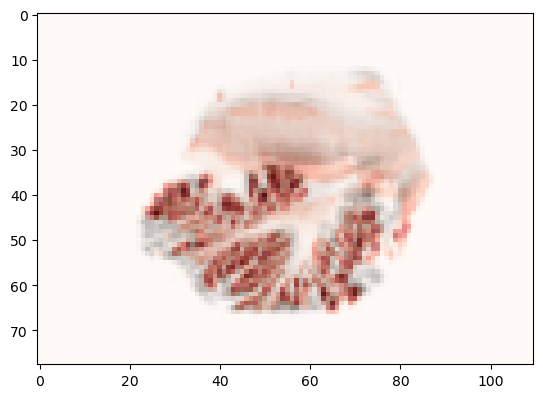

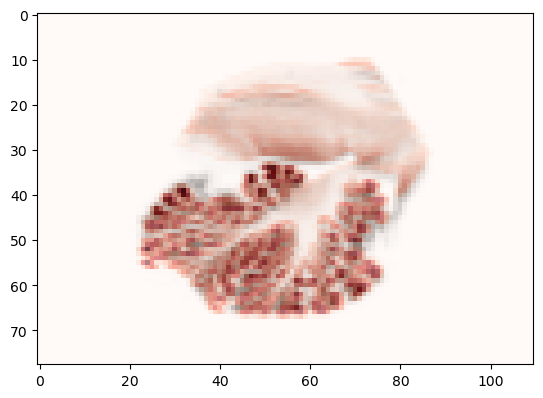

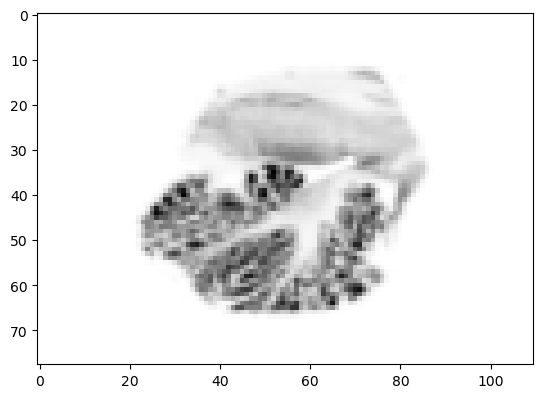

In [29]:
# res = compute_intermediate_slice(pre_img, post_img, current_img=None, idx=None, delete_intermediate_files=True, 
#                                reg_refinement_iterations=3, output_dir=None ,scaling_factor=64, mask_zero=False)

pre = load_volume(pre_img).get_fdata()

post = load_volume(post_img).get_fdata()

plt.imshow(res,alpha=1,cmap='Greys')
plt.imshow(pre,alpha=.5,cmap='Reds')
plt.figure()
plt.imshow(res,alpha=1,cmap='Greys')
plt.imshow(post,alpha=.5,cmap='Reds')
plt.figure()
plt.imshow(res,alpha=1,cmap='Greys')

print(np.corrcoef(np.ravel(res),np.ravel(pre))[0,1])
print(np.corrcoef(np.ravel(res),np.ravel(post))[0,1])



Saving /home/stechr/Documents/code/microscopy_scripts/local_extras/slices/XXX_hist_matched_res.nii.gz


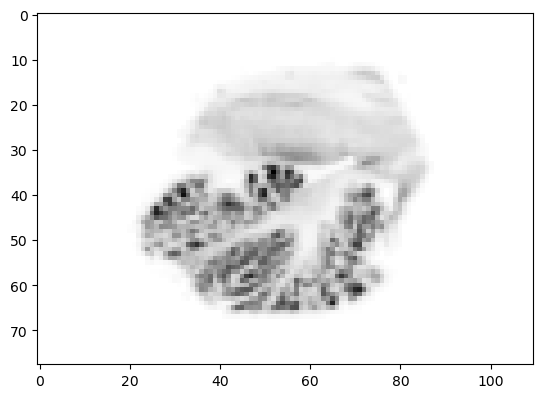

In [30]:
from skimage.exposure import match_histograms
res_matched = res.copy()
m = res_matched>0
res_vec = res[m]
pre_vec = pre[m]
post_vec = post[m]
# Match current slice to the average of its neighbors
matched = match_histograms(res_vec, (pre_vec + post_vec) / 2)
res_matched[m] = matched
plt.imshow(res_matched,alpha=1,cmap='Greys')
save_volume(join(in_dir,'XXX_hist_matched_res.nii.gz'),nibabel.Nifti1Image(res_matched,affine=nibabel.load(pre_img).affine,header=nibabel.load(pre_img).header))


In [86]:

import numpy as np
from scipy.ndimage import laplace, gaussian_filter

def compute_sigma_strength_from_neighbors(pre_img, post_img, sigma_bounds=(0.5, 2.0), strength_bounds=(0.5, 2.0)):
    """
    Estimate adaptive sharpening parameters (sigma, strength) based on neighboring slices.

    Parameters:
        pre_img (ndarray): Image before current slice.
        post_img (ndarray): Image after current slice.
        sigma_bounds (tuple): Min and max allowable sigma.
        strength_bounds (tuple): Min and max allowable strength.
        
    Returns:
        sigma (float): Gaussian sigma for unsharp masking.
        strength (float): Sharpening strength.
    """

    def local_detail_energy(img):
        # High-pass content estimate (Laplacian energy)
        return np.mean(np.abs(laplace(img)))

    def local_contrast(img):
        # Estimate contrast via local standard deviation
        return np.std(img)

    # Compute for both neighbors
    detail_energy = np.mean([local_detail_energy(pre_img), local_detail_energy(post_img)])
    contrast = np.mean([local_contrast(pre_img), local_contrast(post_img)])

    # Normalize to a reasonable scale (empirically tuned based on MRI range)
    # You can refine this mapping for your dataset
    sigma = np.clip(2.0 - detail_energy * 2.0, *sigma_bounds)   # sharper neighbor → smaller sigma
    strength = np.clip(contrast * 1.5, *strength_bounds)        # higher contrast → stronger sharpening

    return sigma, strength

In [87]:
sigma, strength = compute_sigma_strength_from_neighbors(pre,post)
print(sigma,strength)

0.5 2.0



Saving /home/stechr/Documents/code/microscopy_scripts/local_extras/slices/XXX_hist_matched_sharpened_res.nii.gz


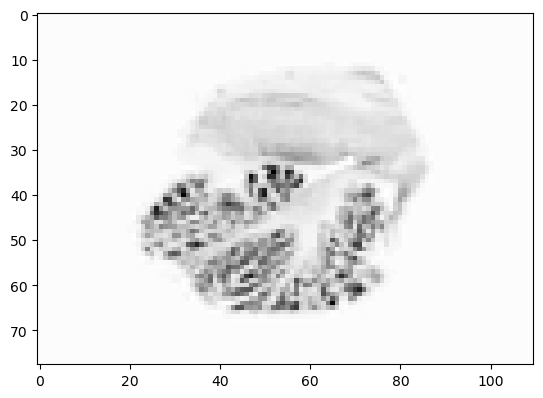

In [41]:
from scipy.ndimage import gaussian_filter

def robust_unsharp_mask(img, sigma=1.0, strength=1.0):
    blurred = gaussian_filter(img, sigma)
    detail = img - blurred
    sharpened = img + strength * detail
    return sharpened

robust_unsharp_masked = robust_unsharp_mask(res_matched, sigma=sigma, strength=strength)
plt.imshow(robust_unsharp_masked,cmap='Greys')
save_volume(join(in_dir,'XXX_hist_matched_sharpened_res.nii.gz'),nibabel.Nifti1Image(robust_unsharp_masked,affine=nibabel.load(pre_img).affine,header=nibabel.load(pre_img).header))


In [36]:
do_reg_ants([pre_img], [post_img], file_name='pre_avg', run_syn=True, output_dir='/home/chris/Documents/code/microscopy_scripts/local_extras/slices/', 
                             scaling_factor=16,mask_zero=False)

{'transformed_source': '/home/chris/Documents/code/microscopy_scripts/local_extras/slices/pre_avg_transformed.nii.gz',
 'rigid_transform': ['pre_avg_rigid_0GenericAffine.mat'],
 'syn_transform': ['pre_avg_syn_1Warp.nii.gz',
  'pre_avg_syn_0GenericAffine.mat']}

NameError: name 'fixed' is not defined

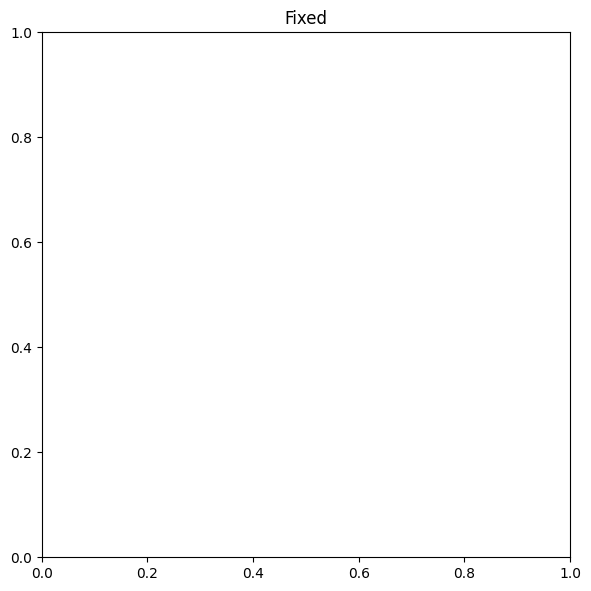

In [17]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.title('Fixed')
plt.imshow(fixed.numpy())
plt.subplot(2,2,2)
plt.title('Warped to fixed')
plt.imshow(mywarpedimage.numpy())
plt.subplot(2,2,3)
plt.title('Average')
plt.imshow(.5*(fixed.numpy()+mywarpedimage.numpy()))

plt.subplot(2,2,4)
plt.title('Difference (fixed-warped)')
plt.imshow((fixed.numpy()-mywarpedimage.numpy()))

plt.subplots_adjust(wspace=0, hspace=0)
# plt.

In [45]:
def compute_scaling_multipliers_from_dataset(image_list, mask_zero=True):
    """
    Compute global multipliers for sigma and sharpening strength based on dataset-wide
    detail energy and contrast.

    Parameters:
        image_list (list of ndarray): List of image volumes.
        mask_zero (bool): Exclude 0-values from stats (e.g., background).

    Returns:
        (sigma_multiplier, strength_multiplier, stats_dict)
    """

    def local_detail_energy(img):
        return np.mean(np.abs(laplace(img[img != 0]))) if mask_zero else np.mean(np.abs(laplace(img)))

    def local_contrast(img):
        return np.std(img[img != 0]) if mask_zero else np.std(img)

    detail_energies = []
    contrasts = []

    for img in image_list:
        detail_energies.append(local_detail_energy(img))
        contrasts.append(local_contrast(img))

    detail_energy_mean = np.mean(detail_energies)
    contrast_mean = np.mean(contrasts)

    # Inverse relationship for sigma → more detail energy = lower sigma
    sigma_multiplier = 1.5 / detail_energy_mean
    strength_multiplier = 2.0 / contrast_mean

    stats = {
        'detail_energy_mean': detail_energy_mean,
        'detail_energy_max': np.max(detail_energies),
        'contrast_mean': contrast_mean,
        'contrast_max': np.max(contrasts),
        'sigma_multiplier': sigma_multiplier,
        'strength_multiplier': strength_multiplier
    }

    return sigma_multiplier, strength_multiplier, stats

In [48]:
compute_scaling_multipliers_from_dataset([pre,post])

(0.0057596415276028184,
 0.0041965691549743465,
 {'detail_energy_mean': 260.43287465223636,
  'detail_energy_max': 292.08170391061446,
  'contrast_mean': 476.57977889613164,
  'contrast_max': 492.16679514190633,
  'sigma_multiplier': 0.0057596415276028184,
  'strength_multiplier': 0.0041965691549743465})

In [ ]:


def unsharp_mask(image, sigma=1.0, strength=1.5):
    blurred = gaussian_filter(image, sigma)
    sharpened = image + strength * (image - blurred)
    return sharpened


In [ ]:
compute_sigma_strength_from_neighbors(pre,post,sigma_multiplier=0.0057596415276028184,strength_multiplier=0.0041965691549743465)

(0.5, 1.6490787859640366)

In [93]:
import numpy as np
from scipy.ndimage import laplace
from scipy.stats import trim_mean

def compute_histogram_matched_slice(current_slice, pre_img_slice, post_img_slice = None):
    """
    Compute a histogram-matched slice for the current slice from one or both of its neighboring slices.
    All inputs should be numpy arrays in the same space since we mask based on the current slice
      - this approach intrinsically misses some data in the neighbours, but has little effect

    Parameters:
        current_slice (ndarray): Current slice to be matched to its neigbours
        pre_img_slice (ndarray): Image before current slice.
        post_img_slice (ndarray): Image after current slice.
    """
    
    current_matched = np.zeros_like(current_slice)
    m = current_slice>0
    current_slice_vec = current_slice[m]
    pre_vec = pre_img_slice[m]

    if post_img_slice is not None:
        # Match current slice to the average of its neighbors
        post_vec = post_img_slice[m]
        matched = match_histograms(current_slice_vec, (pre_vec + post_vec) / 2)
        current_matched[m] = matched
    else:
        #match to the one that was provided
        matched = match_histograms(current_slice_vec, pre_vec)
        current_matched[m] = matched
    return current_matched

def compute_scaling_multipliers_from_dataset(image_list, mask_zero=True, trim_proportion=0.05):
    """
    Computes global scaling multipliers from a dataset to normalize sharpening parameters.

    Parameters:
        image_list (list of ndarray): List of 2D image arrays.
        mask_zero (bool): Whether to exclude zero values from the computation.
        trim_proportion (float): Proportion of values to trim from the high and low ends of the distribution.

    Returns:
        sigma_multiplier (float): Multiplier to convert detail energy into sigma.
        strength_multiplier (float): Multiplier to convert contrast into sharpening strength.
        stats (dict): Dictionary of global statistics.
    """
    detail_energies = []
    contrasts = []

    for img in image_list:
        if mask_zero:
            img = img[img != 0]
        if img.size == 0:
            continue
        detail_energy = np.mean(np.abs(laplace(img)))
        contrast = np.std(img)

        detail_energies.append(detail_energy)
        contrasts.append(contrast)

    # trim to remove 5% of the highest and lowest values
    detail_energy_mean = trim_mean(detail_energies,trim_proportion)
    contrast_mean = trim_mean(contrasts,trim_proportion)

    # Normalize so typical energy/contrast → multiplier * energy ≈ 1.0
    sigma_multiplier = 1.0 / detail_energy_mean if detail_energy_mean > 0 else 1.0
    strength_multiplier = 1.0 / contrast_mean if contrast_mean > 0 else 1.0

    stats = {
        'detail_energy_mean': detail_energy_mean,
        'detail_energy_max': np.max(detail_energies) if detail_energies else 0,
        'contrast_mean': contrast_mean,
        'contrast_max': np.max(contrasts) if contrasts else 0,
        'sigma_multiplier': sigma_multiplier,
        'strength_multiplier': strength_multiplier
    }

    return sigma_multiplier, strength_multiplier, stats


def compute_sigma_strength_from_neighbors(
    pre_img, post_img, sigma_bounds=(0.5, 2.0), strength_bounds=(0.5, 2.0),
    sigma_multiplier=1.0, strength_multiplier=1.0
):
    """
    Computes adaptive sigma and strength from neighboring slices using global scaling multipliers.

    Parameters:
        pre_img (ndarray): Previous slice image.
        post_img (ndarray): Next slice image.
        sigma_bounds (tuple): Min/max bounds for sigma.
        strength_bounds (tuple): Min/max bounds for strength.
        sigma_multiplier (float): Multiplier from dataset for sigma.
        strength_multiplier (float): Multiplier from dataset for sharpening strength.

    Returns:
        sigma (float): Gaussian blur sigma.
        strength (float): Sharpening strength.
    """
    def local_detail_energy(img):
        return np.mean(np.abs(laplace(img)))

    def local_contrast(img):
        return np.std(img)

    # Average detail and contrast from neighbors
    detail_energy = np.mean([local_detail_energy(pre_img), local_detail_energy(post_img)])
    contrast = np.mean([local_contrast(pre_img), local_contrast(post_img)])

    # Apply scaling multipliers
    sigma = np.clip(sigma_multiplier * detail_energy, *sigma_bounds)
    strength = np.clip(strength_multiplier * contrast, *strength_bounds)

    return sigma, strength


In [ ]:
sigma_multiplier, strength_multiplier, stats = compute_scaling_multipliers_from_dataset([pre,post])
sigma, strength = compute_sigma_strength_from_neighbors(
    pre, post,
    sigma_bounds=(0.5, 2.0),
    strength_bounds=(0.5, 2.0),
    sigma_multiplier=sigma_multiplier,
    strength_multiplier=strength_multiplier
)
print(sigma)
print(strength)
sharpened = unsharp_mask(res,sigma=sigma_multiplier,strength=strength_multiplier)


0.8267402358495399
0.8609564449715486



Saving /home/stechr/Documents/code/microscopy_scripts/local_extras/slices/XXX_hist_matched_sharpened_res_v2.nii.gz


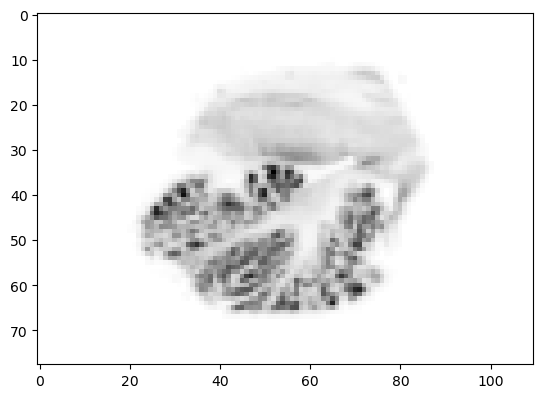

In [96]:
sharpened = compute_histogram_matched_slice(sharpened,pre,post)
plt.imshow(sharpened,cmap='Greys')
save_volume(join(in_dir,'XXX_hist_matched_sharpened_res_v2.nii.gz'),nibabel.Nifti1Image(sharpened,affine=nibabel.load(pre_img).affine,header=nibabel.load(pre_img).header))
